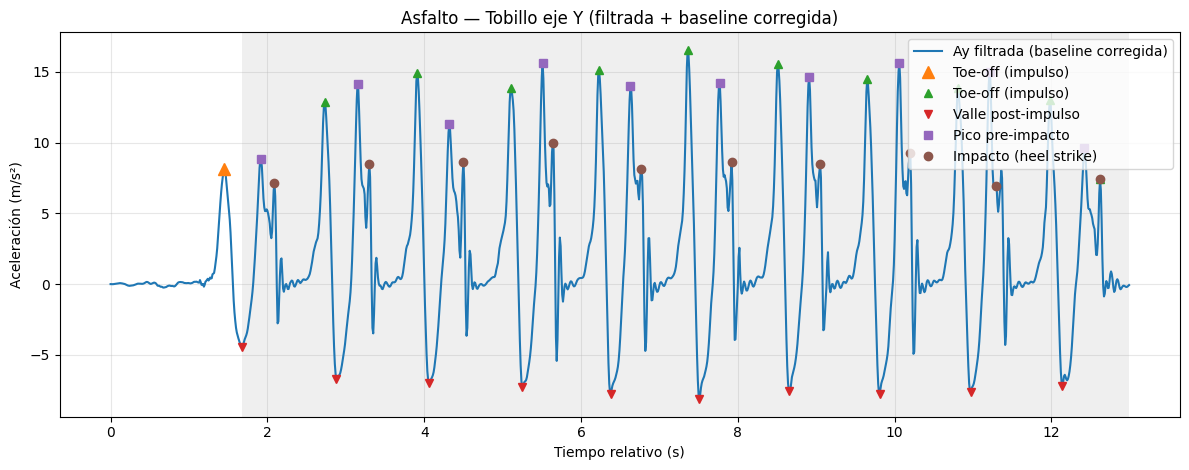


Parámetros por evento — Asfalto
Superficie                        Evento  Media (m/s²)  Desv. típ. (m/s²)  n
   Asfalto Toe-off inicial (valor único)         8.161                NaN  1
   Asfalto             Toe-off (impulso)        13.761              2.506 10
   Asfalto            Valle post-impulso        -7.147              1.033 10
   Asfalto              Pico pre-impacto        13.302              2.463 10
   Asfalto         Impacto (heel strike)         8.322              0.944 10


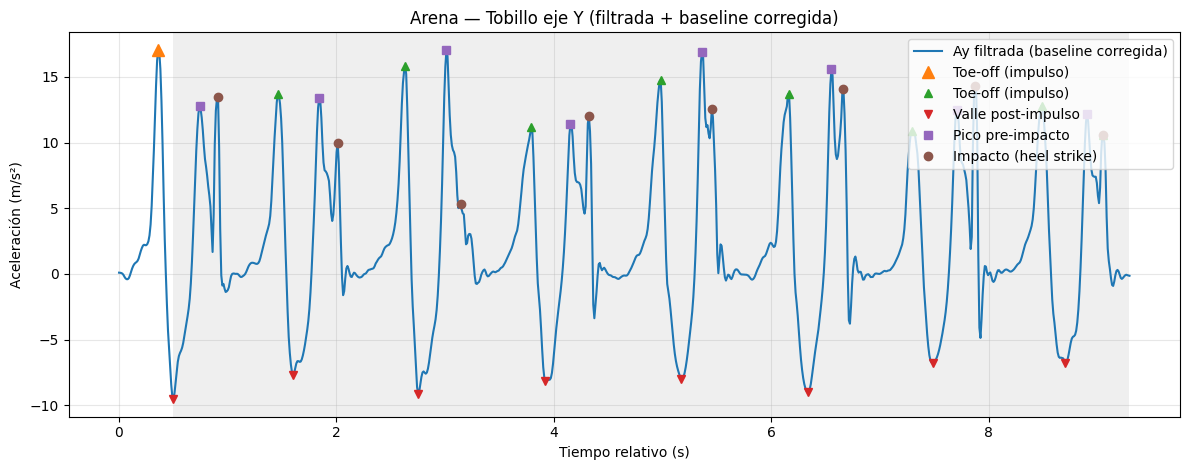


Parámetros por evento — Arena
Superficie                        Evento  Media (m/s²)  Desv. típ. (m/s²)  n
     Arena Toe-off inicial (valor único)        17.053                NaN  1
     Arena             Toe-off (impulso)        12.937              1.918  8
     Arena            Valle post-impulso        -8.131              1.052  8
     Arena              Pico pre-impacto        13.985              2.223  8
     Arena         Impacto (heel strike)        11.535              2.960  8


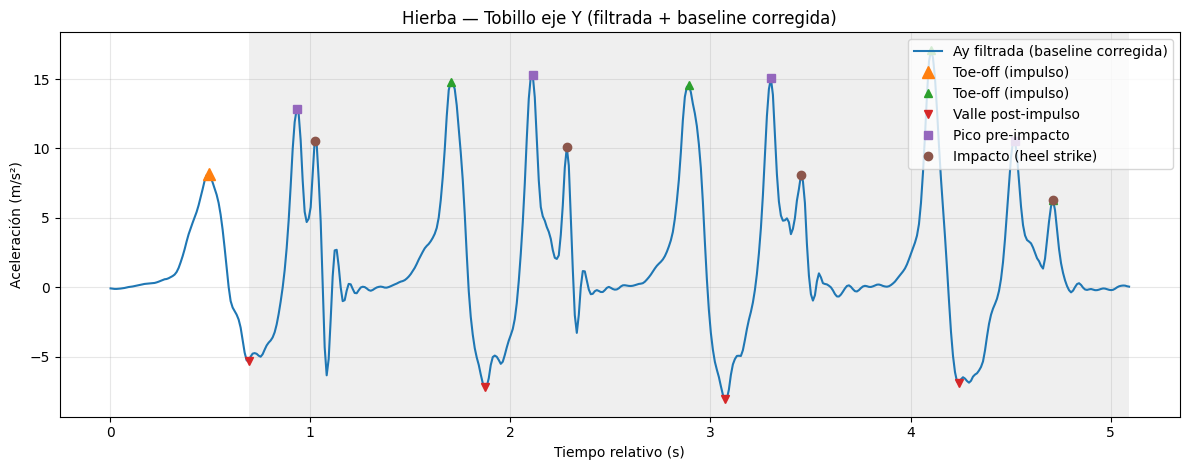


Parámetros por evento — Hierba
Superficie                        Evento  Media (m/s²)  Desv. típ. (m/s²)  n
    Hierba Toe-off inicial (valor único)         8.153                NaN  1
    Hierba             Toe-off (impulso)        13.188              4.740  4
    Hierba            Valle post-impulso        -6.856              1.157  4
    Hierba              Pico pre-impacto        13.416              2.223  4
    Hierba         Impacto (heel strike)         8.743              1.960  4

=== Resumen por superficie (media ± desviación, con n) ===
Superficie                        Evento  Media (m/s²)  Desv. típ. (m/s²)  n
   Asfalto Toe-off inicial (valor único)         8.161                NaN  1
   Asfalto             Toe-off (impulso)        13.761              2.506 10
   Asfalto            Valle post-impulso        -7.147              1.033 10
   Asfalto              Pico pre-impacto        13.302              2.463 10
   Asfalto         Impacto (heel strike)         8.322       

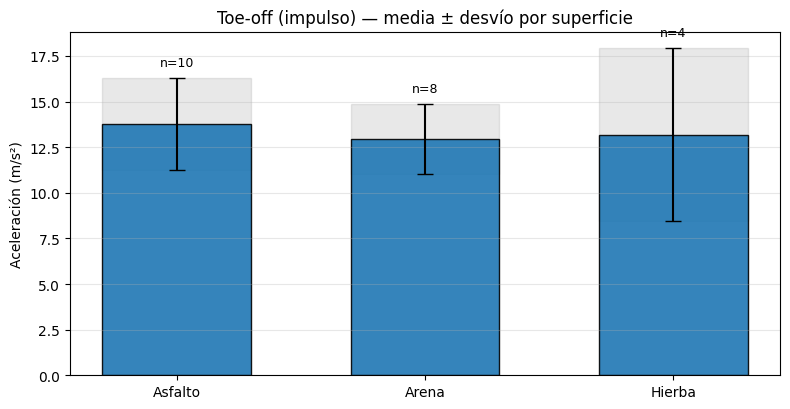

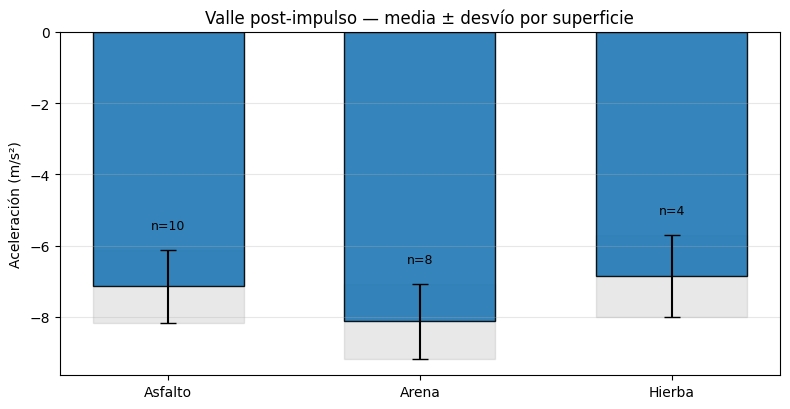

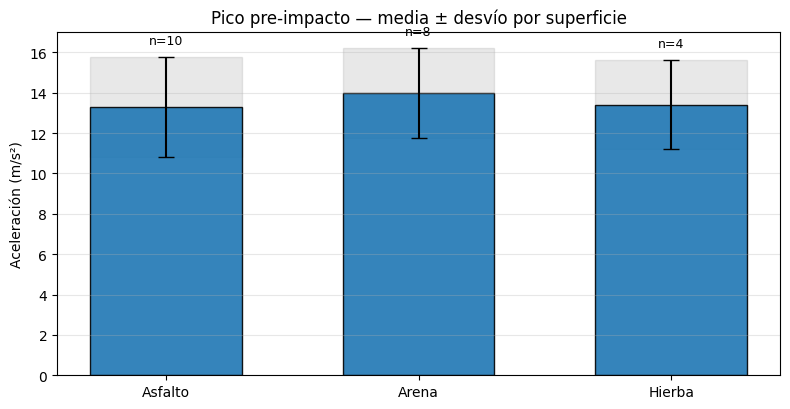

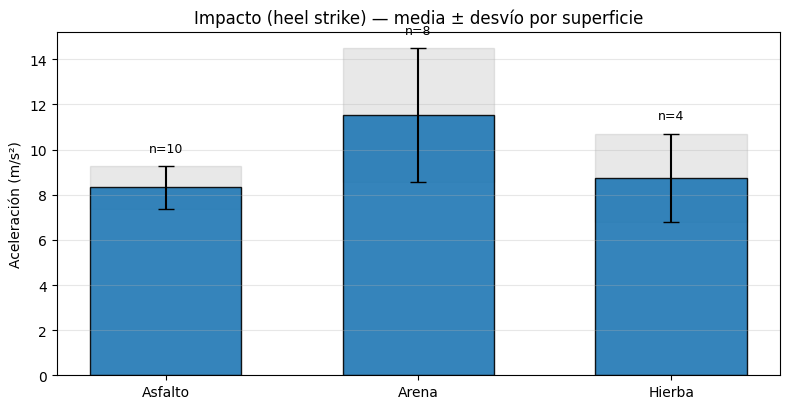

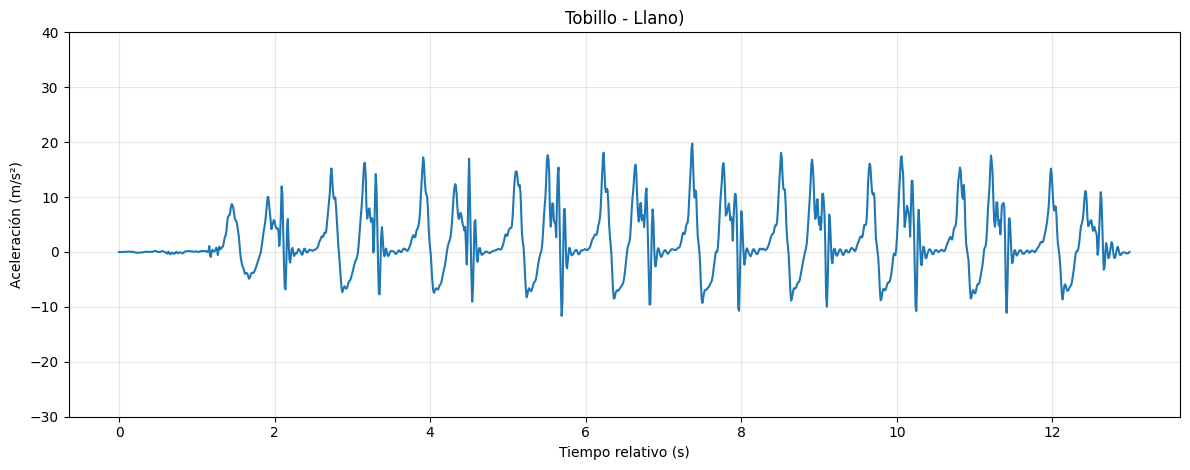

In [4]:
# %%
%matplotlib inline
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.signal import find_peaks

FS = 100.0

INTERVALOS_TOBILLO = {
    "Asfalto": (25.0, 38.0),
    "Arena"  : (26.2, 35.5),
    "Hierba" : (18.65, 23.75),
}

VENTANA_MEDIA = 5

VALLEY_MIN_DIST_S  = { "Asfalto":0.50, "Arena":0.55, "Hierba":0.60 }
VALLEY_MIN_DEPTH   = 3.5
VALLEY_MIN_PROM    = 2.0

# Anchura por lóbulo (entre cruce +→− y cruce −→+). Regla estricta.
MIN_LOBE_WIDTH_S   = { "Asfalto":0.08, "Arena":0.12, "Hierba":0.15 }

# Ventanas temporales
VALLEY_MIN_DT_AFTER_TOE = { "Asfalto":0.12, "Arena":0.20, "Hierba":0.22 }
VALLEY_MAX_DT_AFTER_TOE = { "Asfalto":0.65, "Arena":0.75, "Hierba":0.80 }
TOEOFF_LEAD_MIN = 0.12  # toe-off inicial debe preceder al primer valle ≥ 120 ms
TOEOFF_LEAD_MAX = 0.70  # y ≤ 700 ms

PEAK_MIN_DIST_S   = 0.12
PREIMPACT_MAX_GAP = 0.45
IMPACT_MAX_GAP    = 0.30
TOEOFF_LOOKBACK   = 0.80

IMPACT_WIDTH_MIN_S= 0.02
IMPACT_WIDTH_MAX_S= 0.10

ABS_THR_POS = 1.0
ABS_THR_NEG = 1.0
TOEOFF_MIN_HEIGHT_FACTOR = 0.2

# ---------------- utilidades ----------------
def buscar_fichero(surface):
    exact = f"Accelerometer{surface}Tobillo.csv"
    if os.path.exists(exact): return exact
    for f in glob.glob("Accelerometer*.csv"):
        if re.match(fr"(?i)Accelerometer{surface}Tobillo\.csv$", os.path.basename(f)): return f
    raise FileNotFoundError(f"No se encontró Accelerometer{surface}Tobillo.csv")

def cargar_tobillo(surface):
    f = buscar_fichero(surface)
    df = pd.read_csv(f)
    df.columns = [c.strip().lower() for c in df.columns]
    t  = pd.to_numeric(df["seconds_elapsed"], errors="coerce").to_numpy()
    ay = pd.to_numeric(df["y"], errors="coerce").to_numpy()
    return t, ay

def recortar(t, y, t0, t1):
    m = (t >= t0) & (t <= t1)
    return t[m]-t0, y[m]

def media_movil(x, k):
    if k <= 1: return x
    return np.convolve(x, np.ones(k)/k, mode="same")

def mad_std(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    return 1.4826*mad if mad>0 else np.std(x)

def zero_cross_lobe_width(time, y, center_idx):
    """Anchura (s) del lóbulo negativo que contiene center_idx (entre cruces por cero)."""
    n = len(y)
    tL = None
    for i in range(center_idx-1, 0, -1):
        if y[i] >= 0 and y[i+1] < 0:
            frac = y[i] / (y[i] - y[i+1] + 1e-12)
            tL = time[i] + frac*(time[i+1]-time[i]); break
    tR = None
    for i in range(center_idx, n-1):
        if y[i] < 0 and y[i+1] >= 0:
            frac = (-y[i]) / (y[i+1] - y[i] + 1e-12)
            tR = time[i] + frac*(time[i+1]-time[i]); break
    if tL is None or tR is None: return 0.0
    return max(0.0, tR - tL)

# ---------------- núcleo (detección) ----------------
def detectar_eventos(surface, time, ay):
    ay_s  = media_movil(ay, VENTANA_MEDIA)
    sigma = mad_std(ay_s)
    thr_pos = max(ABS_THR_POS, 0.9*sigma)
    thr_neg = max(ABS_THR_NEG, 0.9*sigma)

    valley_min_dist = int(VALLEY_MIN_DIST_S[surface]*FS)
    peak_min_dist   = int(PEAK_MIN_DIST_S*FS)
    min_lobe        = MIN_LOBE_WIDTH_S[surface]

    # Candidatos de valles por profundidad/prominencia/separación
    valleys0, _ = find_peaks(
        -ay_s,
        height=max(thr_neg, VALLEY_MIN_DEPTH),
        prominence=VALLEY_MIN_PROM,
        distance=valley_min_dist
    )

    # FILTRO ESTRICTO por lóbulo
    valleys = []
    for v in valleys0:
        if zero_cross_lobe_width(time, ay_s, v) >= min_lobe:
            valleys.append(v)
    valleys = np.array(valleys, dtype=int)

    # Picos positivos
    pos_peaks, _ = find_peaks(ay_s, height=thr_pos, distance=int(PEAK_MIN_DIST_S*FS))

    # ======= PRIMER VALLE (Hierba: forzar en el primer segundo) =======
    if surface == "Hierba":
        t_end = min(1.0, time[-1]-1e-6)
        j_end = np.searchsorted(time, t_end, side="right")
        if j_end > 2:
            lm, _ = find_peaks(-ay_s[:j_end], height=0.0, prominence=1.0)
            for vidx in lm:
                if zero_cross_lobe_width(time, ay_s, vidx) >= min_lobe:
                    valleys = np.array([vidx] + [v for v in valleys if v > vidx], dtype=int)
                    break

    # Si aún no hay valle inicial pero hubo candidatos crudos, quédate con el primero filtrado
    if valleys.size == 0 and valleys0.size:
        v1 = valleys0[0]
        if zero_cross_lobe_width(time, ay_s, v1) >= min_lobe:
            valleys = np.array([v1], dtype=int)

    # ======= Toe‑off INICIAL: obligatoriamente ANTES del primer valle =======
    toeoff_inicial, toeoff0_idx = None, None
    if valleys.size:
        v_first = valleys[0]
        # ventana: [v_first - TOEOFF_LEAD_MAX, v_first - TOEOFF_LEAD_MIN]
        a = max(0, v_first - int(TOEOFF_LEAD_MAX*FS))
        b = max(0, v_first - int(TOEOFF_LEAD_MIN*FS))
        cand = pos_peaks[(pos_peaks >= a) & (pos_peaks <= b)]
        if cand.size:
            toeoff0_idx = cand[np.argmax(ay_s[cand])]
        else:
            seg = ay_s[a:b] if b > a else np.array([])
            if seg.size:
                j = np.argmax(seg)
                if seg[j] > max(TOEOFF_MIN_HEIGHT_FACTOR*sigma, 0.0):
                    toeoff0_idx = a + j
        if toeoff0_idx is not None:
            toeoff_inicial = (time[toeoff0_idx], ay_s[toeoff0_idx])

    # ======= Ciclos valle→valle (+ último → fin) =======
    cycles = [(valleys[i], valleys[i+1]) for i in range(len(valleys)-1)]
    if len(valleys) >= 1 and (not cycles or cycles[-1][1] < len(ay_s)-1):
        cycles.append((valleys[-1], len(ay_s)-1))

    # ======= Etiquetado por ciclo =======
    eventos = []
    for (start, end) in cycles:
        if end - start < max(12, int(0.25*FS)):
            continue

        peaks = pos_peaks[(pos_peaks > start) & (pos_peaks < end)]

        # pre‑impacto = primer pico tras el valle (ventana)
        pre_idx = np.nan
        if peaks.size:
            max_k = start + int(PREIMPACT_MAX_GAP*FS)
            cand = peaks[peaks <= min(end-1, max_k)]
            if cand.size: pre_idx = cand[0]

        # impacto = siguiente pico tras pre (estrecho)
        imp_idx = np.nan
        if np.isfinite(pre_idx):
            wmin = max(1, int(IMPACT_WIDTH_MIN_S*FS))
            wmax = max(wmin+1, int(IMPACT_WIDTH_MAX_S*FS))
            right_limit = min(end-1, int(pre_idx)+int(IMPACT_MAX_GAP*FS))
            seg = slice(int(pre_idx)+1, right_limit)
            pk, prop = find_peaks(ay_s[seg], height=thr_pos, width=(wmin, wmax))
            if pk.size:
                imp_idx = (int(pre_idx)+1) + pk[0]
            else:
                nxt = peaks[peaks > pre_idx]
                if nxt.size and nxt[0] <= right_limit: imp_idx = nxt[0]

        # toe‑off (de ciclo) = último pico en la cola; fallback máximo local positivo
        toe_idx = np.nan
        left = max(start, end - int(TOEOFF_LOOKBACK*FS))
        tail = pos_peaks[(pos_peaks >= left) & (pos_peaks < end)]
        if tail.size:
            toe_idx = tail[-1]
        else:
            seg = ay_s[left:end]
            if seg.size:
                j = np.argmax(seg)
                if seg[j] > max(0.1, TOEOFF_MIN_HEIGHT_FACTOR*sigma):
                    toe_idx = left + j

        if not np.isnan(toe_idx):
            eventos.append(dict(
                t_toe=time[int(toe_idx)], a_toe=ay_s[int(toe_idx)],
                t_valley=time[int(start)], a_valley=ay_s[int(start)],
                t_pre=(time[int(pre_idx)] if np.isfinite(pre_idx) else np.nan),
                a_pre=(ay_s[int(pre_idx)] if np.isfinite(pre_idx) else np.nan),
                t_impact=(time[int(imp_idx)] if np.isfinite(imp_idx) else np.nan),
                a_impact=(ay_s[int(imp_idx)] if np.isfinite(imp_idx) else np.nan),
            ))

    return ay_s, eventos, cycles, toeoff_inicial

# ---------- helpers de stats ----------
def stats_de_eventos(eventos):
    """Devuelve dict con medias, std y n de cada evento (aceleraciones)."""
    arr = pd.DataFrame(eventos) if eventos else pd.DataFrame(columns=["a_toe","a_valley","a_pre","a_impact"])
    def _ms(col):
        v = pd.to_numeric(arr[col], errors="coerce").dropna()
        return dict(mean=float(v.mean()) if len(v) else np.nan,
                    std=float(v.std(ddof=1)) if len(v)>1 else np.nan,
                    n=int(len(v)))
    return {
        "Toe-off (impulso)": _ms("a_toe"),
        "Valle post-impulso": _ms("a_valley"),
        "Pico pre-impacto": _ms("a_pre"),
        "Impacto (heel strike)": _ms("a_impact"),
    }

def tabla_surface(surface, stats, toeoff_inicial):
    rows = []
    for nombre, d in stats.items():
        rows.append([surface, nombre, d["mean"], d["std"], d["n"]])
    df = pd.DataFrame(rows, columns=["Superficie","Evento","Media (m/s²)","Desv. típ. (m/s²)","n"])
    if toeoff_inicial is not None:
        df_to = pd.DataFrame([[surface, "Toe-off inicial (valor único)", toeoff_inicial[1], np.nan, 1]],
                             columns=df.columns)
        df = pd.concat([df_to, df], ignore_index=True)
    return df

# ---------- pipeline de graficado + stats ----------
def procesar_y_graficar(surface):
    t, ay = cargar_tobillo(surface)
    t0, t1 = INTERVALOS_TOBILLO[surface]
    tt, yy = recortar(t, ay, t0, t1)

    ay_s, evs, cycles, toeoff0 = detectar_eventos(surface, tt, yy)

    # Plot señal con eventos
    plt.figure(figsize=(12, 4.8))
    plt.title(f"{surface} — Tobillo eje Y (filtrada + baseline corregida)")
    plt.plot(tt, ay_s, label="Ay filtrada (baseline corregida)")
    for s, e in cycles:
        t_end = tt[e] if e < len(tt) else tt[-1]
        plt.axvspan(tt[s], t_end, color='gray', alpha=0.12, lw=0)

    if toeoff0 is not None:
        plt.plot(toeoff0[0], toeoff0[1], "^", ms=9, label="Toe‑off (impulso)")

    if evs:
        df_e = pd.DataFrame(evs)
        if "t_toe" in df_e:
            plt.plot(df_e["t_toe"], df_e["a_toe"], "^", label="Toe‑off (impulso)")
        if "t_valley" in df_e:
            plt.plot(df_e["t_valley"], df_e["a_valley"], "v", label="Valle post‑impulso")
        if "t_pre" in df_e:
            plt.plot(df_e["t_pre"], df_e["a_pre"], "s", label="Pico pre‑impacto")
        if "t_impact" in df_e:
            plt.plot(df_e["t_impact"], df_e["a_impact"], "o", label="Impacto (heel strike)")

    plt.xlabel("Tiempo relativo (s)")
    plt.ylabel("Aceleración (m/s²)")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Stats
    s = stats_de_eventos(evs)
    df_tab = tabla_surface(surface, s, toeoff0)
    print(f"\nParámetros por evento — {surface}")
    print(df_tab.to_string(index=False, float_format=lambda v: f"{v:6.3f}"))

    return df_tab

# Ejecutar y compilar resumen
resumen = []
for sup in ["Asfalto", "Arena", "Hierba"]:
    resumen.append(procesar_y_graficar(sup))

df_resumen = pd.concat(resumen, ignore_index=True)
print("\n=== Resumen por superficie (media ± desviación, con n) ===")
print(df_resumen.to_string(index=False, float_format=lambda v: f"{v:6.3f}"))

# ---------------- Gráficas de barras comparativas ----------------
def barras_evento(df_resumen, nombre_evento, ylim=None):
    sub = df_resumen[(df_resumen["Evento"] == nombre_evento) &
                     (df_resumen["Superficie"].isin(["Asfalto","Arena","Hierba"]))]
    if sub.empty:
        print(f"(Sin datos para {nombre_evento})")
        return
    # Orden fijo por superficie
    sub = sub.set_index("Superficie").loc[["Asfalto","Arena","Hierba"]].reset_index()

    labels = sub["Superficie"].values
    means  = sub["Media (m/s²)"].values
    stds   = sub["Desv. típ. (m/s²)"].values
    ns     = sub["n"].values

    x = np.arange(len(labels))
    width = 0.6

    fig, ax = plt.subplots(figsize=(8,4.2))
    bars = ax.bar(x, means, width, yerr=stds, capsize=6, edgecolor="black", alpha=0.9)
    # franja sombreada (±1 std) por barra
    for xi, m, s in zip(x, means, stds):
        if np.isnan(s): continue
        ax.add_patch(Rectangle((xi - width/2, m - s), width, 2*s, color="gray", alpha=0.18, zorder=0))

    # anotamos n encima
    for xi, m, n in zip(x, means, ns):
        ax.text(xi, m + (stds[np.where(x==xi)][0] if len(stds)>0 and not np.isnan(stds).all() else 0) + 0.5,
                f"n={int(n)}", ha="center", va="bottom", fontsize=9)

    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_ylabel("Aceleración (m/s²)")
    ax.set_title(f"{nombre_evento} — media ± desvío por superficie")
    ax.grid(True, axis="y", alpha=0.3)
    if ylim: ax.set_ylim(*ylim)
    plt.tight_layout()
    plt.show()

# Pintamos una gráfica por punto notable (excluimos el toe-off inicial único)
eventos_bar = ["Toe-off (impulso)", "Valle post-impulso", "Pico pre-impacto", "Impacto (heel strike)"]
for ev in eventos_bar:
    barras_evento(df_resumen, ev)

# Pintamos una grafica de la aceleracion del eje Y en asfalto, con la escala del eje vertical de 40 a -30
def graficar_aceleracion_asfalto():
    surface = "Asfalto"
    t, ay = cargar_tobillo(surface)
    t0, t1 = INTERVALOS_TOBILLO[surface]
    tt, yy = recortar(t, ay, t0, t1)

    plt.figure(figsize=(12, 4.8))
    plt.title(f"Tobillo - Llano)")
    plt.plot(tt, yy, label="Tobillo Y")
    plt.xlabel("Tiempo relativo (s)")
    plt.ylabel("Aceleración (m/s²)")
    plt.ylim(-30, 40)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
graficar_aceleracion_asfalto()
